# Preparing data for segmentation

It is critical that any classification should be sufficiently robust so that it may be applied to the ships at any port or at any geographic area in open sea. As speed over ground (SOG) and rate of turn (ROT) do not suffer from these drawbacks they were chosen as more suitable inputs to the segmentation

In [1]:
# base libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import json
from random import randint

In [2]:
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
shipping_rot_filename = config['DEFAULT']['shipping_rot_filename']
seg_prep_filename = config['DEFAULT']['seg_prep_filename']
all_segment_variables_filename = config['DEFAULT']['all_segment_variables_filename']

In [3]:
# import data
dtype_dic = {'MMSI':int,'dt':'str', 'lat':'float', 'long':'float','SOG':'float', 'rot':'float', 
             'Type':'str', 'gross_tonnage':'float','vessel_name':'str', 'ETA':'str', 'POC_LOCODE':'str',
             'last_port_LOCODE':'str', 'next_port_LOCODE':'str', 'status':'str','voyage_id':'float','tripid':int,
            'in_hazmat':'str','out_hazmat':'str'}
parse_dates = ['dt', 'ETA']

shipping_data = pd.read_csv(processing_path + shipping_rot_filename,header = 0,delimiter = ',',dtype = dtype_dic, parse_dates=parse_dates)

To remove noise created by smaller ships such as tugs and ferries, only consider the following ship types; Container ships, General cargo ships, Chemical / oil product tankers, Cargo ships and Bulk carriers

In [4]:
extract_mask = (shipping_data['Type'] == 'container ship') | (shipping_data['Type'] == 'general cargo ship') | (shipping_data['Type'] == 'chemical / oil product tanker') | (shipping_data['Type'] == 'cargo ship') | (shipping_data['Type'] == 'bulk carrier')
shipping_data = shipping_data[extract_mask].copy(deep = True)

In [5]:
# keep only the fields needed for segmentation and drop rows with a missing rot field
seg_prep = shipping_data[['MMSI','dt','tripid','SOG','rot']]
seg_prep = seg_prep.dropna(subset=['rot'])

## Distribution of SOG and ROT

Histograms of the SOG and ROT values are created and converted into two state vectors, SOG and ROT. Essentially each state vector represents a historical distribution of the individual SOG and ROT values across the preceding two minutes. The bin boundaries for the SOG and ROT state vectors were selected to ensure approximately equal quantile population density across the entire training dataset.

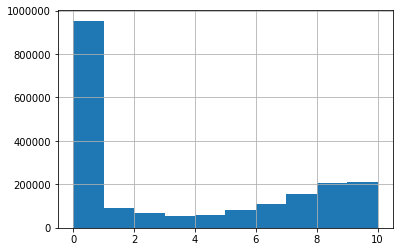

In [6]:
seg_prep['SOG'].hist(range=(0,10))
plt.show()

In [7]:
# the histogram suggests the following
bin_max_sog = seg_prep['SOG'].max()+1
bins_sog = [-1,0,1,2,3,5,10,bin_max_sog]
groups_sog = ['0','1','2','3','4','5','6']

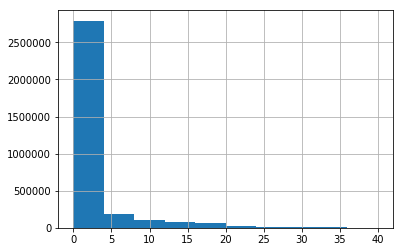

In [8]:
seg_prep['rot'].dropna().hist(range=(0,40))
plt.show()

In [9]:
# the histogram suggests the following
bin_max_rot = seg_prep['rot'].max()+1
bins_rot = [-1, 0.1, 0.6, 2.5, 8, bin_max_rot]
groups_rot = ['0','1','2','3','4']

In [10]:
def get_state_space_dist(df,variable,bins,groups):
    
    """
    Cuts a variable into the specified bins and derives a dummy variable for each bin
    Parameters
      df: a dataframe containing the variable to cut
      variable: a variable to cut
      df_new: the name of the new dataframe
      bins: the bin boundaries
      groups: the label for each bin
      
    Returns a dataframe with a column for each bin
    """
    
    df_new = pd.cut(df[variable], bins, labels=groups)
    df_new = pd.get_dummies(df_new, prefix=variable)

    df_new = df[['MMSI','dt']].merge(df_new,left_index = True,right_index = True,how = 'inner')
    
    df_new = df_new.set_index(['MMSI','dt'])
    
    return df_new

In [11]:
sog = get_state_space_dist(seg_prep,'SOG',bins_sog,groups_sog)

In [12]:
rot = get_state_space_dist(seg_prep,'rot',bins_rot,groups_rot)

In [13]:
seg_variables = sog.merge(rot,left_index = True,right_index = True,how = 'inner')

## Random window selection

A segmentaton could be built based on each timestamp taken in isolation at every point along the track of each ship. However this would likely lead to noisy segments with very few containing unique or intuitive behaviours. As this approach treats each AIS data point in isolation, with no consideration given to the relationship between points over time, it is overly sensitive to noise within the AIS data, caused by atmospheric effects, obsolete equipment or on-board interference.

A more robust approach is to add a time-based aggregated component to the SOG and ROT fields that reduces the sensitivity of the segmentation to AIS signal noise. For each journey, a random two-minute slice of AIS data is taken during the voyage. 

In [14]:
# only want to build the segmentation on the in port data
seg_variables_ip = seg_variables.reset_index()
in_port = shipping_data[shipping_data.status == 'In Port']
seg_variables_ip = seg_variables_ip.merge(in_port[['MMSI','dt']], how = 'inner', on = ['MMSI','dt'])
seg_variables_ip = seg_variables_ip.set_index(['MMSI','dt'])

In [15]:
# define the window length in seconds
window_duration = 120
nloops = 20
# unique list of MMSIs
mmsi_list = set(shipping_data['MMSI'][shipping_data.status == 'In Port'])

In [16]:
# create an empty dictionary to add summarised results to
sog_rot_dict = {}

for i in range(0,nloops):

    # loop through each MMSI and extract a portion of points
    # the end point is random, the start point is defined by 'window_duration'
    for curr_mmsi in mmsi_list:

        tmp1 = seg_variables_ip.loc[curr_mmsi]

        # get end of extract window based on a random row for the extracted data and find the associated 
        # time stamp of this window
        end_idx = randint(0, (tmp1.shape[0]-1))
        window_end = tmp1.index[end_idx]

        # get start date of the extract window, this is the window_end minus the user defined window_duration
        window_start = window_end - datetime.timedelta(seconds = window_duration)      

        # extract the points that fall within the extract window
        tmp2 = tmp1.loc[window_start:window_end]

        # aggregate to a total across the 2 min window tmp2 is a series
        tmp2 = tmp2.sum()
        
        sog_rot_dict[(curr_mmsi,window_end)] = tmp2.to_dict()

In [17]:
# convert the dictionary to a dataframe
seg_prep_rand = pd.DataFrame.from_dict(sog_rot_dict, "index")

In [18]:
# function to convert a value to the percentage of the row total
def get_pct(x):
    return(x/(x.sum()))

In [19]:
sog_rand = seg_prep_rand[['SOG_0','SOG_1','SOG_2','SOG_3','SOG_4','SOG_5', 'SOG_6']]
sog_rand = sog_rand.apply(get_pct,axis = 1)

In [20]:
rot_rand = seg_prep_rand[['rot_0','rot_1','rot_2','rot_3','rot_4']]
rot_rand = rot_rand.apply(get_pct,axis = 1)

In [21]:
seg_prep_rand = sog_rand.merge(rot_rand,left_index = True,right_index = True,how = 'inner')

## Data Extract

In [22]:
# exporting sample data for applying k means clustering and deciding final segments
seg_prep_rand.to_csv(processing_path + seg_prep_filename,header=True,index=True,sep=',')

In [23]:
seg_prep_rand.describe()

,SOG_0,SOG_1,SOG_2,SOG_3,SOG_4,SOG_5,SOG_6,rot_0,rot_1,rot_2,rot_3,rot_4
count,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000,13413.000000
mean,0.101058,0.147689,0.056167,0.042752,0.065424,0.551635,0.035275,0.370972,0.361034,0.136384,0.074582,0.057028
std,0.289052,0.334792,0.203728,0.176596,0.226062,0.487442,0.172054,0.291551,0.268156,0.203185,0.157564,0.152764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.363636,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.583333,0.583333,0.230769,0.076923,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# exporting all data with sog and rot banding for applying segmentation
seg_variables.to_csv(processing_path + all_segment_variables_filename,header=True,index=True,sep=',')

In [25]:
seg_variables.describe()

,SOG_0,SOG_1,SOG_2,SOG_3,SOG_4,SOG_5,SOG_6,rot_0,rot_1,rot_2,rot_3,rot_4
count,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06,3.299386e+06
mean,1.893598e-01,1.029637e-01,2.592634e-02,1.985430e-02,3.525323e-02,2.280194e-01,3.986233e-01,3.740496e-01,3.201756e-01,1.119023e-01,9.632004e-02,9.755239e-02
std,3.917942e-01,3.039115e-01,1.589156e-01,1.394995e-01,1.844192e-01,4.195552e-01,4.896150e-01,4.838766e-01,4.665440e-01,3.152463e-01,2.950297e-01,2.967085e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
